# Setup

In [1]:
from pqdm.processes import pqdm
import requests
import statsmodels.api as sm

from utils import *

# Compute travel times

In [2]:
centroids = pd.read_parquet('data/geometry/centroids.parquet').disp()

143,971 rows x 5 cols; Memory: 24.4 MiB


,geoid,level,city,x,y
,<object>,<object>,<object>,<float32>,<float32>
0,42007,county,pittsburgh,-80.349266,40.682495


## OSRM
**OSRM**: Open-Source Routing Machine

Set up a server for each combination of city and mode using [osrm_server.sh](osrm_server.sh):

```bash osrm_server.sh $city $mode```

 Once the server hits up and running, run [get_ttm_osrm.py](get_ttm_osrm.py) to extract travel times and write the data to disk:
 
 ```python get_ttm_osrm.py -c $city -m $mode```
 
 This is a 2-step manual and time-consuming process.

## R5
Directly extract travel times using [get_ttm_r5.py](get_ttm_r5.py) that uses the `R5py` package (working properly in the `r5` conda environment):

```python get_ttm_r5.py -c $city -M $mode```

For times by public transit, GTFS data zip files are needed.

## GDM
Extract travel times using the Google Distance Matrix (GDM) API using a script: `python get_ttm_gdm.py`
and then store the processed data in `data/ttm/gdm_2020.parquet`.

# Analysis

In [3]:
def get_zones(city):
    return gpd.read_parquet(
        'data/geometry/zones.parquet',
        columns=['geoid', 'geometry'],
        filters=[('city', '==', city), ('level', '==', 'BG')])

## Compare with GDM

In [4]:
gdm = pd.read_parquet('data/ttm/gdm_2020.parquet',
                      columns=['mode', 'src', 'trg', 'time'],
                      filters=[('level', '==', 'BG')])
gdm['gdm'] = (gdm.pop('time') / 60).astype(F32)
gdm.disp();

8,072,582 rows x 4 cols; Memory: 132.2 MiB


,mode,src,trg,gdm
,<category>,<category>,<category>,<float32>
0,Bike,181379685002,181379685003,6.066667


In [9]:
gdmvsosrm = []
for city in tqdm(['Indianapolis', 'Chicago']):
    for mode in ['Bike', 'Drive', 'Walk']:
        df = pd.read_parquet('data/ttm/osrm/{}_{}_bg.parquet'
                             .format(city.lower(), mode.lower()),
                             columns=['src', 'trg', 'time'])
        df = df[(df.src.str[:2] == '18') & (df.trg.str[:2] == '18')]
        df['osrm'] = (df.pop('time') / 60).astype(F32)
        df = df.merge(filt(gdm, mode=mode), on=['src', 'trg'])
        gdmvsosrm.append(df.assign(city=city, mode=mode))
gdmvsosrm = (pd.concat(gdmvsosrm).reset_index(drop=1)
             .astype(D(city=CAT, mode=CAT))
             [['city', 'mode', 'osrm', 'gdm']]).disp() # 21s

  0%|          | 0/2 [00:00<?, ?it/s]

3,037,240 rows x 4 cols; Memory: 29.0 MiB


,city,mode,osrm,gdm
,<category>,<category>,<float32>,<float32>
0,Indianapolis,Bike,50.661667,39.033333


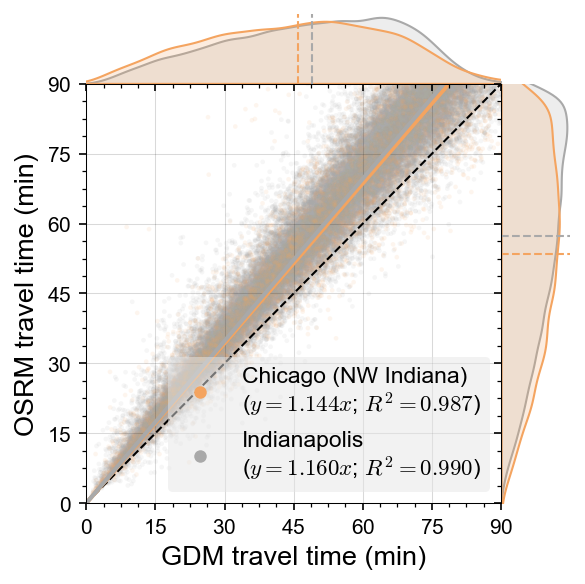

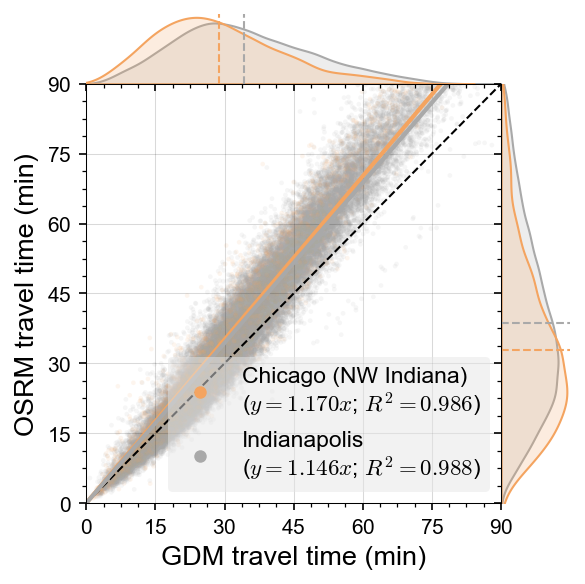

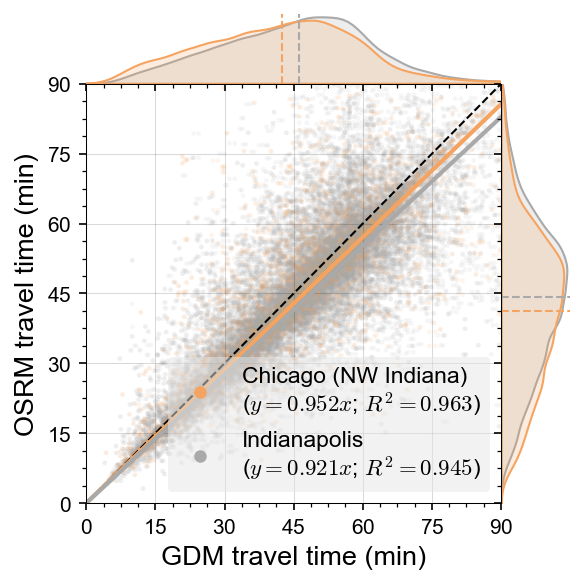

In [15]:
tmax = 90
city_colors = D(Chicago='sandybrown', Indianapolis='darkgrey')
for mode in ['Bike', 'Drive', 'Walk']:
    data = (filt(gdmvsosrm, mode=mode)
            .sample(frac=1, random_state=1234).head(50_000))
    g = sns.jointplot(
        data, x='gdm', y='osrm', hue='city',
        palette=list(city_colors.values()), alpha=0.1, edgecolor='none',
        height=4, xlim=(0, tmax), ylim=(0, tmax), space=0,
        ratio=6, marginal_kws=D(alpha=0.2, common_norm=False),
        joint_kws=D(s=5, legend=False))
    g.figure.set_dpi(150)
    ax = plot(g.ax_joint, xlab='GDM travel time (min)',
              ylab='OSRM travel time (min)')
    ax.plot(*[[0, tmax]] * 2, color='k', lw=1, ls='--')
    ax.set_xticks(ticks := np.arange(0, tmax + 1, 15))
    ax.set_yticks(ticks)
    axX, axY = g.ax_marg_x, g.ax_marg_y
    handles = []
    for city, color in city_colors.items():
        df = filt(data, city=city)
        model = sm.OLS(df['osrm'], df[['gdm']]).fit()
        ymax = tmax * (slope := model.params.iloc[0])
        r2 = model._results.rsquared
        label = '%s\n($y=%.3fx$; $R^2=%.3f$)' % (
            city + ' (NW Indiana)' if city == 'Chicago' else city, slope, r2)
        ax.plot([0, tmax], [0, ymax], color=color, lw=2)
        axX.axvline(df['gdm'].mean(), color=color, ls='--', lw=1)
        axY.axhline(df['osrm'].mean(), color=color, ls='--', lw=1)
        handles += [mpl.lines.Line2D([0], [0], label=label, color='none',
                                     marker='o', markerfacecolor=color,
                                     markeredgecolor='none')]
    ax.legend(handles=handles, loc='lower right')
    for ax in [axX, axY]:
        ax.grid(alpha=0)
    imsave(f'GDM vs OSRM for {mode}') # 10s

In [13]:
gdmvsosrm.groupby(['mode', 'city'], observed=1)[['osrm', 'gdm']].mean()

osrm        gdm
mode  city                              
Bike  Chicago       53.467747  45.928226
      Indianapolis  57.373581  48.832432
Drive Chicago       32.485355  28.412266
      Indianapolis  38.558792  34.150185
Walk  Chicago       41.225536  42.325405
      Indianapolis  44.253269  46.148472

In [16]:
gdmvsosrm.groupby(['mode'], observed=1)[['osrm', 'gdm']].mean()

,osrm,gdm
mode,,
Bike,56.643673,48.289703
Drive,37.790962,33.424770
Walk,43.554825,45.266560


In [ ]:
def compare_osrm_r5(city, modes=('Bike', 'Drive', 'Walk')):
    city = city.lower().replace(' ', '-')
    r5vsosrm = []
    for mode in modes:
        try:
            osrm = pd.read_parquet(
                f'data/ttm/osrm/{city}_{mode.lower()}_bg.parquet',
                columns=['src', 'trg', 'time'])
            osrm['osrm'] = (osrm.pop('time') / 60).astype(F16)
            r5 = pd.read_parquet(glob(f'data/ttm/r5/{city}_{mode.lower()}*')[0],
                                 filters=[('level', '==', 'BG')],
                                 columns=['src', 'trg', 'time'])
            r5 = r5.astype(D(src=osrm.src.dtype, trg=osrm.trg.dtype, time=F16))
            r5.rename(columns=D(time='r5'), inplace=True)
            tt = r5.merge(osrm, on=('src', 'trg'))
            r5vsosrm.append(tt.assign(mode=mode.title()))
        except Exception as e:
            print('ERROR:', city, mode, e)
    r5vsosrm = pd.concat(r5vsosrm).reset_index(drop=1).astype(D(mode=CAT))
    return r5vsosrm

osrmr5_indy = compare_osrm_r5('Indianapolis').disp()

1,835,676 rows x 5 cols; Memory: 16.0 MiB


,src,trg,r5,osrm,mode
,<category>,<category>,<float16>,<float16>,<category>
0,181095102024,181095102024,0.0,0.0,Bike


## OSRM vs R5

In [ ]:
# r5vsosrm = []
# for file in tqdm(sorted(glob('data/osm/city/*'))):
#     city = file.split('/')[-1].split('.')[0]
#     df = compare_osrm_r5(city)
#     df['city'] = city.replace('-', ' ').replace('.', '').title()
#     r5vsosrm.append(df)
# r5vsosrm = pd.concat(r5vsosrm).astype(D(city=CAT)).disp()
# r5vsosrm.to_parquet('data/ttm/r5_vs_osrm.parquet') # 9m52s
r5vsosrm = pd.read_parquet('data/ttm/r5_vs_osrm.parquet').disp() # 16s

541,440,525 rows x 4 cols; Memory: 3098.2 MiB


,osrm,r5,city,mode
,<float16>,<float16>,<category>,<category>
0,0.0,0.0,Atlanta,Bike


### OSRM vs R5 in Indy

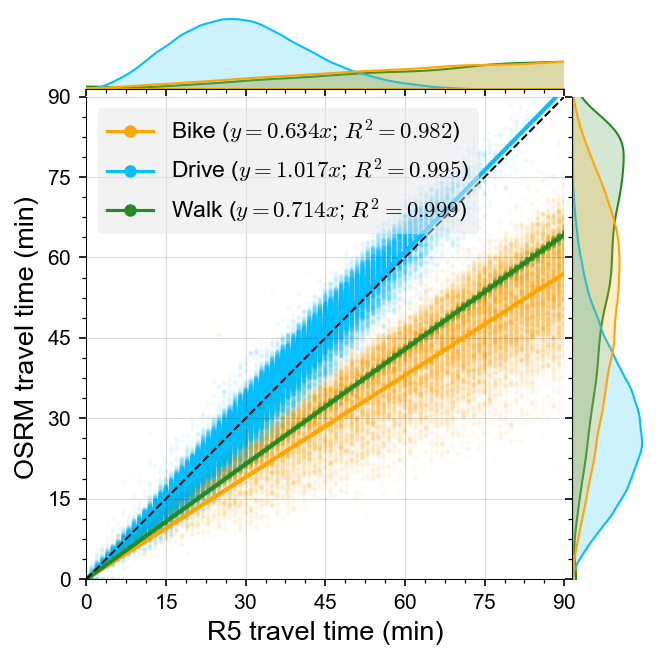

In [ ]:
city, tmax = 'Indianapolis', 90
data = filt(r5vsosrm, city=city).astype(D(r5=F32, osrm=F32))
data = data.sample(200_000, random_state=1234)
modes = ['Bike', 'Drive', 'Walk']
colors = ['#FFA500', '#03BFFF', '#238B21']
g = sns.jointplot(data, x='r5', y='osrm', hue='mode',
                  palette=colors, alpha=0.05, edgecolor='none',
                  height=4.5, xlim=(0, tmax), ylim=(0, tmax), space=0.1,
                  ratio=6, marginal_kws=D(alpha=0.2, common_norm=False),
                  joint_kws=D(s=5))
g.figure.set_dpi(150)
ax = plot(g.ax_joint, xlab='R5 travel time (min)', ylab='OSRM travel time (min)')
ax.set_xticks(ticks := np.arange(0, tmax + 1, 15))
ax.set_yticks(ticks)
handles = []
for mode, color in zip(modes, colors):
    df = filt(data, mode=mode)
    model = sm.OLS(df.osrm, df[['r5']]).fit()
    ymax = tmax * (slope := model.params.iloc[0])
    r2 = model._results.rsquared
    label = '%s ($y=%.3fx$; $R^2=%.3f$)' % (mode, slope, r2)
    ax.plot([0, tmax], [0, ymax], color=color, lw=2)
    handles += [mpl.lines.Line2D(
        [0], [0], label=label, marker='o', color=color,
        markeredgecolor='none', markerfacecolor=color)]
ax.plot(*[[0, tmax]] * 2, color='k', lw=1, ls='--')
ax.legend(handles=handles, loc='upper left')
for ax in [g.ax_marg_x, g.ax_marg_y]:
    ax.grid(alpha=0)
imsave('OSRM vs R5 time distribution in Indianapolis') # 15s

### OSRM vs R5 for all cities

In [ ]:
# def func(input_):
#     _, df = input_
#     model = sm.OLS(df.osrm, df[['r5']]).fit()
#     return D(city=df.city.iloc[0], mode=df['mode'].iloc[0],
#              slope=model.params.iloc[0], r2=model._results.rsquared)
# grouped = (r5vsosrm.astype(D(r5=F32, osrm=F32))
#            .query('city not in ("Bridgeport", "Hartford", "Tucson")')
#            .groupby(['city', 'mode'], observed=1))
# ols_fits = Pdf(pqdm(grouped, func, n_jobs=12, total=len(grouped))).disp() # 2m3s
# ols_fits.to_parquet('data/ttm/r5_vs_osrm_ols_fits.parquet')
ols_fits = pd.read_parquet('data/ttm/r5_vs_osrm_ols_fits.parquet').disp()

139 rows x 4 cols; Memory: 0.0 MiB


,city,mode,slope,r2
,<object>,<object>,<float32>,<float64>
0,Atlanta,Bike,0.647659,0.983752


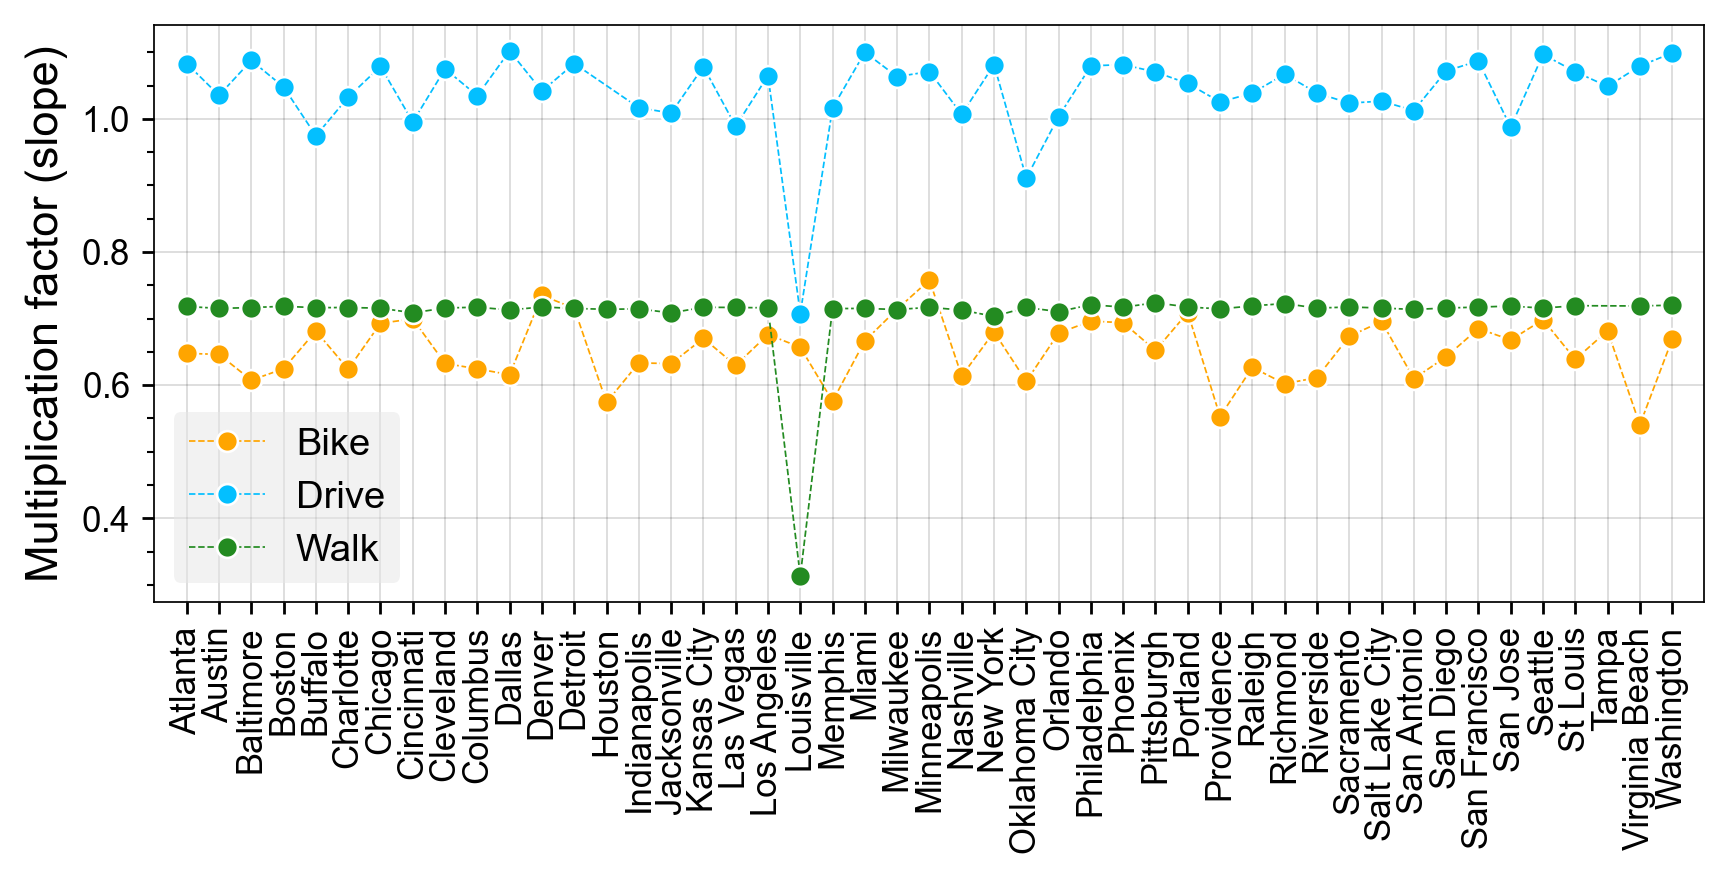

In [ ]:
ncity = ols_fits.city.nunique()
ax = plot(size=(8, 3), dpi=250, xminor=0, xlim=(-1, ncity),
          ylab='Multiplication factor (slope)')
sns.lineplot(ols_fits, x='city', y='slope', hue='mode', ax=ax,
             palette=['#FFA500', '#03BFFF', '#238B21'],
             marker='o', linewidth=0.5, linestyle='--')
ax.set_xticks(range(ncity), ols_fits.city.unique(), rotation=90)
ax.get_legend().set_title('')
ax.set_xlabel('')
imsave('OSRM vs R5 in all cities') # 5s